# HAI Security Dataset Analysis

This notebook is used to convert HAI security datasets from CSV format to Parquet format and perform basic visualization analysis.

## 1. Import Required Libraries

In [2]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pyarrow as pa
import pyarrow.parquet as pq
import glob
from datetime import datetime
import time
from tqdm.notebook import tqdm

# Import custom module
import csv_to_parquet as ctp

# Set plot style
plt.style.use('ggplot')
sns.set(style="whitegrid")
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 12

## 2. Define Dataset Paths

In [3]:
# Define dataset directories
base_dir = 'hai-security-dataset'
dataset_dirs = [
    os.path.join(base_dir, 'hai-20.07'),
    os.path.join(base_dir, 'hai-21.03'),
    os.path.join(base_dir, 'hai-22.04'),
    os.path.join(base_dir, 'hai-23.05'),
    os.path.join(base_dir, 'haiend-23.05')
]

# Check if directories exist
for dir_path in dataset_dirs:
    if not os.path.exists(dir_path):
        print(f"Warning: Directory does not exist: {dir_path}")
    else:
        print(f"Directory exists: {dir_path}")

Directory exists: hai-security-dataset\hai-20.07
Directory exists: hai-security-dataset\hai-21.03
Directory exists: hai-security-dataset\hai-22.04
Directory exists: hai-security-dataset\hai-23.05
Directory exists: hai-security-dataset\haiend-23.05


## 3. Convert CSV Files to Parquet Format

In [4]:
# Create output directory
output_dir = 'parquet_data'
os.makedirs(output_dir, exist_ok=True)

# Convert all datasets
all_converted_files = []

for dataset_dir in tqdm(dataset_dirs, desc="Processing datasets"):
    dataset_name = os.path.basename(dataset_dir)
    print(f"\nProcessing dataset: {dataset_name}")
    
    # Get all CSV files
    csv_files = glob.glob(os.path.join(dataset_dir, '**', '*.csv'), recursive=True)
    
    for csv_file in tqdm(csv_files, desc=f"Converting files in {dataset_name}"):
        # Create relative path
        rel_path = os.path.relpath(csv_file, base_dir)
        # Set output path
        output_path = os.path.join(output_dir, os.path.splitext(rel_path)[0] + '.parquet')
        # Create output directory
        os.makedirs(os.path.dirname(output_path), exist_ok=True)
        
        try:
            # Convert CSV to Parquet
            ctp.convert_csv_to_parquet(csv_file, output_path)
            all_converted_files.append((csv_file, output_path))
        except Exception as e:
            print(f"Conversion failed: {csv_file}, Error: {str(e)}")

print(f"\nTotal converted files: {len(all_converted_files)}")

Processing datasets:   0%|          | 0/5 [00:00<?, ?it/s]


Processing dataset: hai-20.07


Converting files in hai-20.07:   0%|          | 0/4 [00:00<?, ?it/s]


Processing dataset: hai-21.03


Converting files in hai-21.03:   0%|          | 0/8 [00:00<?, ?it/s]


Processing dataset: hai-22.04


Converting files in hai-22.04:   0%|          | 0/10 [00:00<?, ?it/s]


Processing dataset: hai-23.05


Converting files in hai-23.05:   0%|          | 0/8 [00:00<?, ?it/s]


Processing dataset: haiend-23.05


Converting files in haiend-23.05:   0%|          | 0/8 [00:00<?, ?it/s]


Total converted files: 38


## 4. Get Dataset Information

In [5]:
# Get information for all datasets
dataset_info = {}

for dataset_dir in dataset_dirs:
    dataset_name = os.path.basename(dataset_dir)
    # Set Parquet data directory
    parquet_dir = os.path.join(output_dir, dataset_name)
    
    if os.path.exists(parquet_dir):
        # Get dataset information
        info = ctp.get_dataset_info(parquet_dir)
        dataset_info[dataset_name] = info
        
        print(f"Dataset: {dataset_name}")
        print(f"  Number of files: {info['num_files']}")
        print(f"  Total rows: {info['total_rows']}")
        print(f"  Average columns: {info['avg_columns']:.2f}")
    else:
        print(f"Warning: Parquet data directory does not exist: {parquet_dir}")

Dataset: hai-20.07
  Number of files: 4
  Total rows: 995400
  Average columns: 64.00
Dataset: hai-21.03
  Number of files: 8
  Total rows: 1323608
  Average columns: 84.00
Dataset: hai-22.04
  Number of files: 10
  Total rows: 1365602
  Average columns: 88.00
Dataset: hai-23.05
  Number of files: 8
  Total rows: 1465200
  Average columns: 65.75
Dataset: haiend-23.05
  Number of files: 8
  Total rows: 1465200
  Average columns: 170.00


## 5. Basic Dataset Visualization

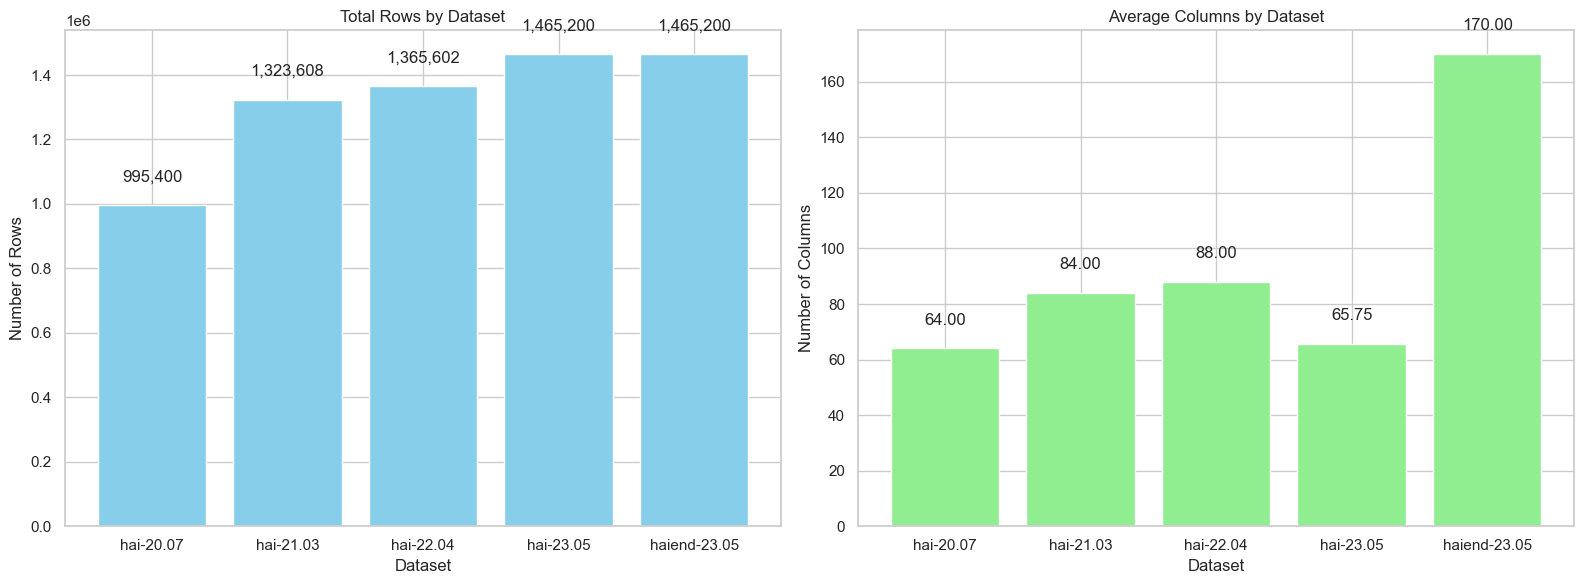

In [6]:
# Plot dataset size comparison
dataset_names = list(dataset_info.keys())
total_rows = [info['total_rows'] for info in dataset_info.values()]
avg_columns = [info['avg_columns'] for info in dataset_info.values()]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Plot total rows bar chart
ax1.bar(dataset_names, total_rows, color='skyblue')
ax1.set_title('Total Rows by Dataset')
ax1.set_xlabel('Dataset')
ax1.set_ylabel('Number of Rows')
ax1.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
for i, v in enumerate(total_rows):
    ax1.text(i, v + 0.05 * max(total_rows), f"{v:,}", ha='center')

# Plot average columns bar chart
ax2.bar(dataset_names, avg_columns, color='lightgreen')
ax2.set_title('Average Columns by Dataset')
ax2.set_xlabel('Dataset')
ax2.set_ylabel('Number of Columns')
for i, v in enumerate(avg_columns):
    ax2.text(i, v + 0.05 * max(avg_columns), f"{v:.2f}", ha='center')

plt.tight_layout()
plt.show()

## 6. Read and Analyze Parquet Files

In [7]:
# Select a dataset for detailed analysis
selected_dataset = 'hai-21.03'  # Can be changed to other datasets
parquet_dir = os.path.join(output_dir, selected_dataset)

# Get all Parquet files
parquet_files = glob.glob(os.path.join(parquet_dir, '*.parquet'))

if parquet_files:
    # Select the first file for analysis
    sample_file = parquet_files[0]
    print(f"Analyzing file: {sample_file}")
    
    # Read Parquet file
    df = pd.read_parquet(sample_file)
    
    # Display basic information
    print("\nBasic Data Information:")
    print(f"Number of rows: {df.shape[0]}")
    print(f"Number of columns: {df.shape[1]}")
    
    # Display first few rows
    print("\nFirst 5 rows of data:")
    display(df.head())
    
    # Display data types
    print("\nData Types:")
    display(df.dtypes)
    
    # Detect time column
    time_column = ctp.detect_time_column(df)
    if time_column:
        print(f"\nTime range: {df[time_column].min()} to {df[time_column].max()}")
else:
    print(f"Warning: No Parquet files found in: {parquet_dir}")

Analyzing file: parquet_data\hai-21.03\test1.parquet

Basic Data Information:
Number of rows: 43201
Number of columns: 84

First 5 rows of data:


,time,P1_B2004,P1_B2016,P1_B3004,P1_B3005,P1_B4002,P1_B4005,P1_B400B,P1_B4022,P1_FCV01D,...,P4_ST_GOV,P4_ST_LD,P4_ST_PO,P4_ST_PS,P4_ST_PT01,P4_ST_TT01,attack,attack_P1,attack_P2,attack_P3
0,2020-07-07 15:00:00,0.10178,1.58771,403.78854,985.37353,32.59527,100.0,2839.58520,36.81010,100.0,...,20469.0,386.26666,380.31683,0,10044.0,27567.0,0,0,0,0
1,2020-07-07 15:00:01,0.10178,1.58725,403.78854,985.37353,32.59527,100.0,2843.37549,36.80895,100.0,...,20489.0,386.30286,380.02747,0,10040.0,27564.0,0,0,0,0
2,2020-07-07 15:00:02,0.10178,1.59519,403.78854,985.37353,32.59527,100.0,2845.06006,36.82879,100.0,...,20604.0,389.73883,381.52850,0,10037.0,27565.0,0,0,0,0
3,2020-07-07 15:00:03,0.10178,1.59747,403.78854,985.37353,32.59527,100.0,2837.33911,36.83451,100.0,...,20633.0,388.94311,382.08911,0,10040.0,27560.0,0,0,0,0
4,2020-07-07 15:00:04,0.10178,1.59869,403.78854,985.37353,32.59527,100.0,2843.37549,36.83756,100.0,...,20738.0,389.72082,383.44543,0,10042.0,27564.0,0,0,0,0



Data Types:


time          datetime64[ns]
P1_B2004             float64
P1_B2016             float64
P1_B3004             float64
P1_B3005             float64
                   ...      
P4_ST_TT01           float64
attack                 int64
attack_P1              int64
attack_P2              int64
attack_P3              int64
Length: 84, dtype: object


Time range: 2020-07-07 15:00:00 to 2020-07-08 03:00:00


## 7. Time Series Data Visualization

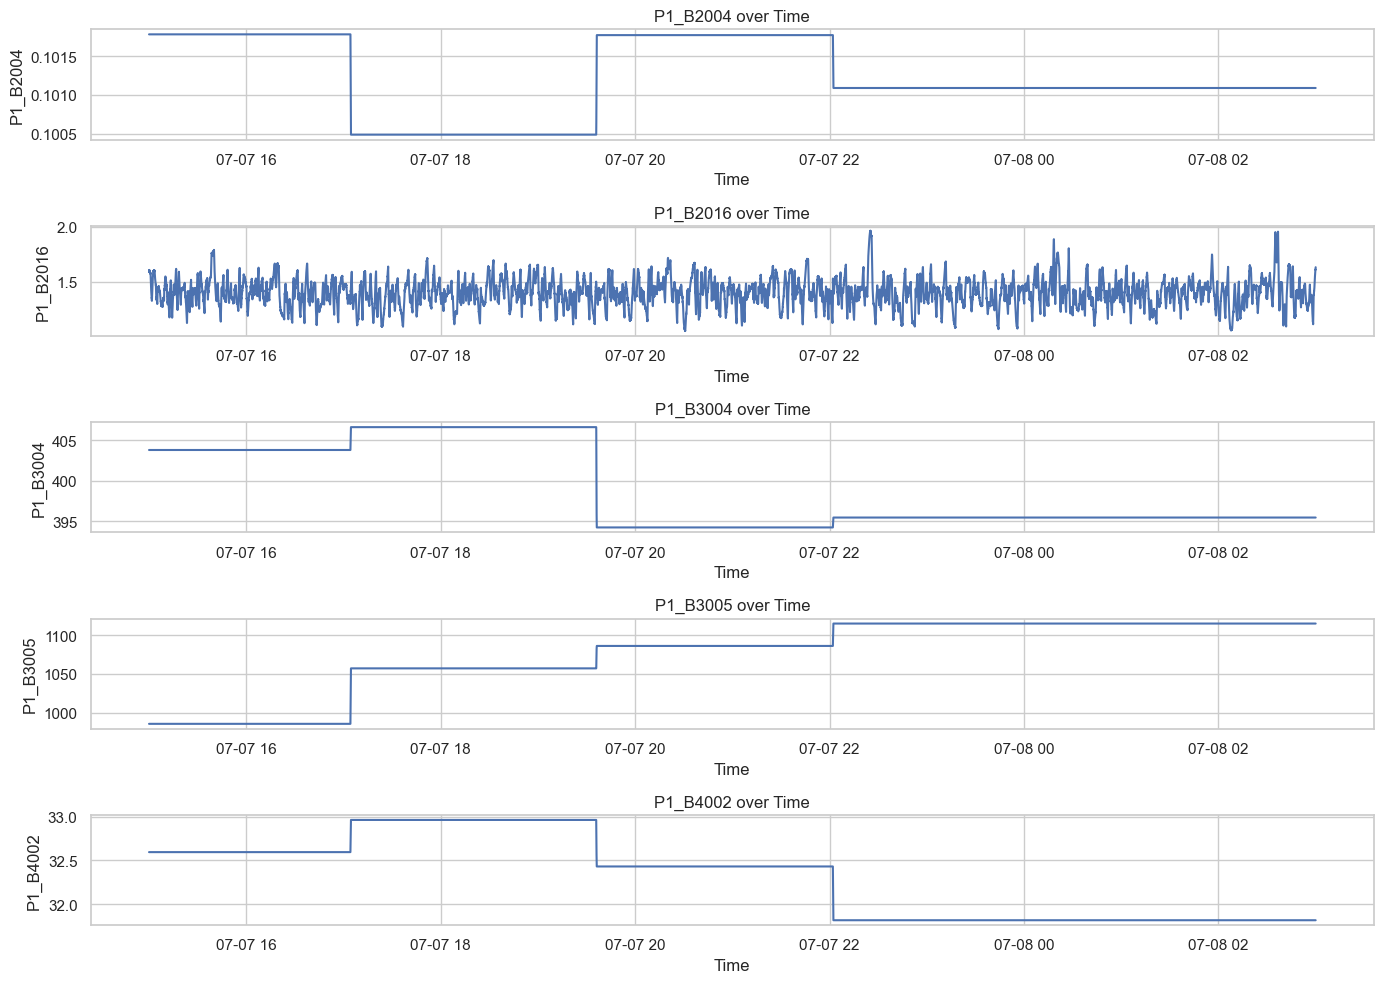

In [8]:
# If there's a time column, plot time series
if parquet_files and time_column:
    # Select some numeric columns for visualization
    numeric_cols = df.select_dtypes(include=['number']).columns.tolist()
    
    # If there are too many numeric columns, select only the first 5
    if len(numeric_cols) > 5:
        selected_cols = numeric_cols[:5]
    else:
        selected_cols = numeric_cols
    
    # Plot time series
    plt.figure(figsize=(14, 10))
    
    for i, col in enumerate(selected_cols):
        plt.subplot(len(selected_cols), 1, i+1)
        plt.plot(df[time_column], df[col])
        plt.title(f'{col} over Time')
        plt.xlabel('Time')
        plt.ylabel(col)
        plt.grid(True)
    
    plt.tight_layout()
    plt.show()

## 8. Correlation Analysis

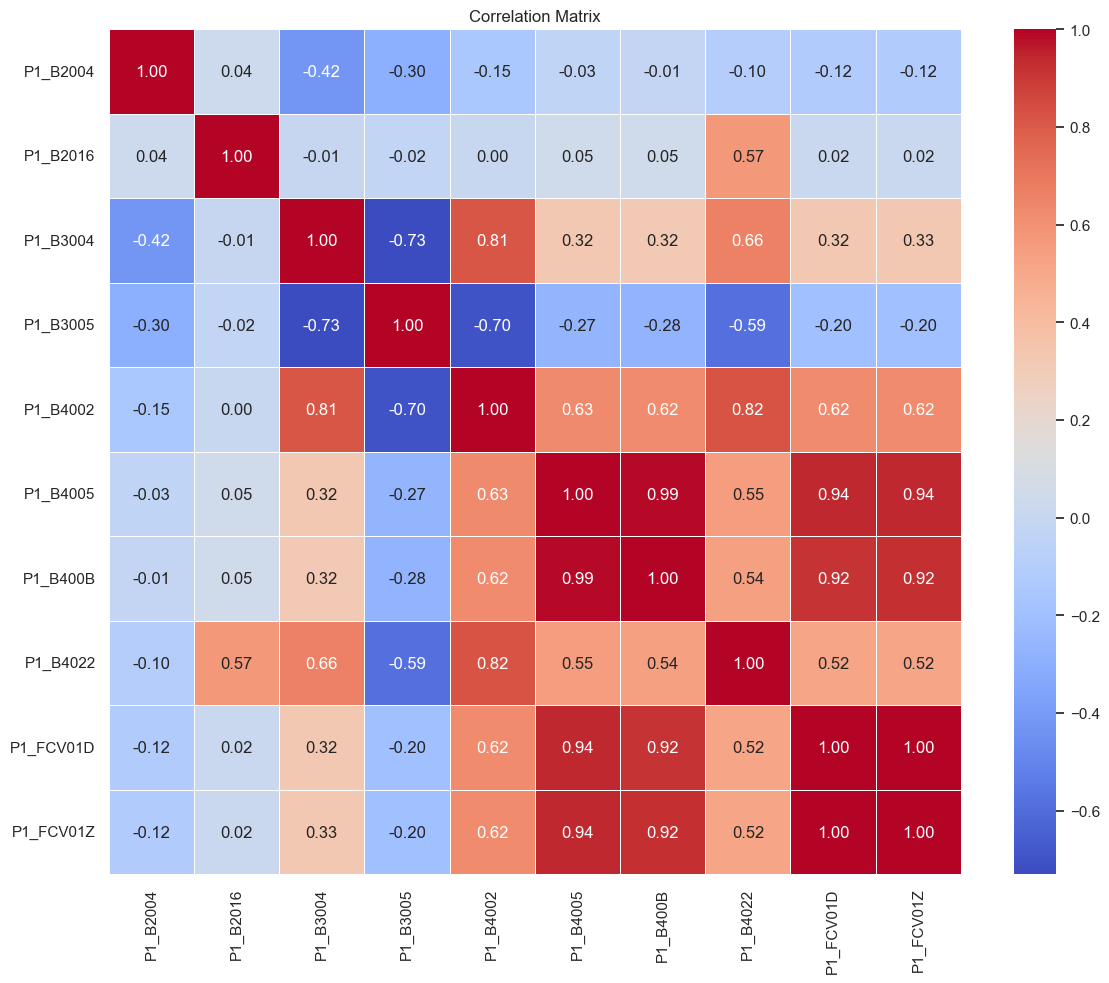

In [9]:
# Calculate correlation matrix
if parquet_files:
    # Select numeric columns
    numeric_cols = df.select_dtypes(include=['number']).columns.tolist()
    
    # If there are too many numeric columns, select only the first 10
    if len(numeric_cols) > 10:
        selected_cols = numeric_cols[:10]
    else:
        selected_cols = numeric_cols
    
    # Calculate correlation matrix
    corr_matrix = df[selected_cols].corr()
    
    # Plot correlation heatmap
    plt.figure(figsize=(12, 10))
    sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
    plt.title('Correlation Matrix')
    plt.tight_layout()
    plt.show()

## 9. Attack Analysis

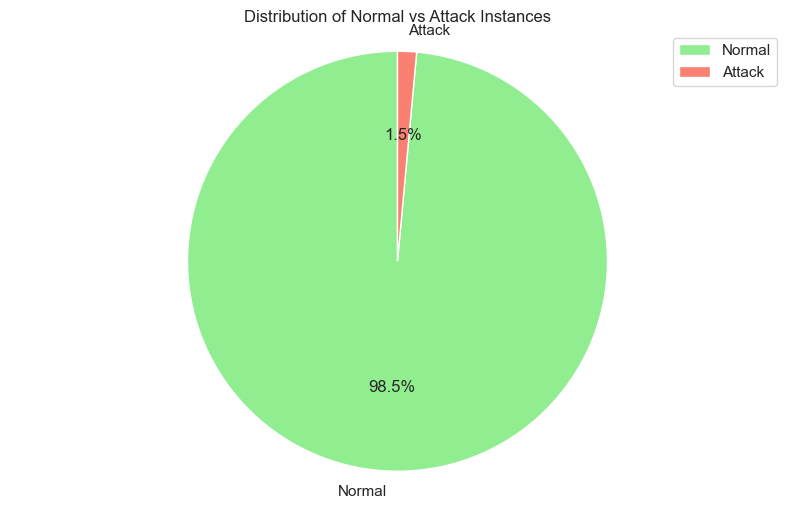

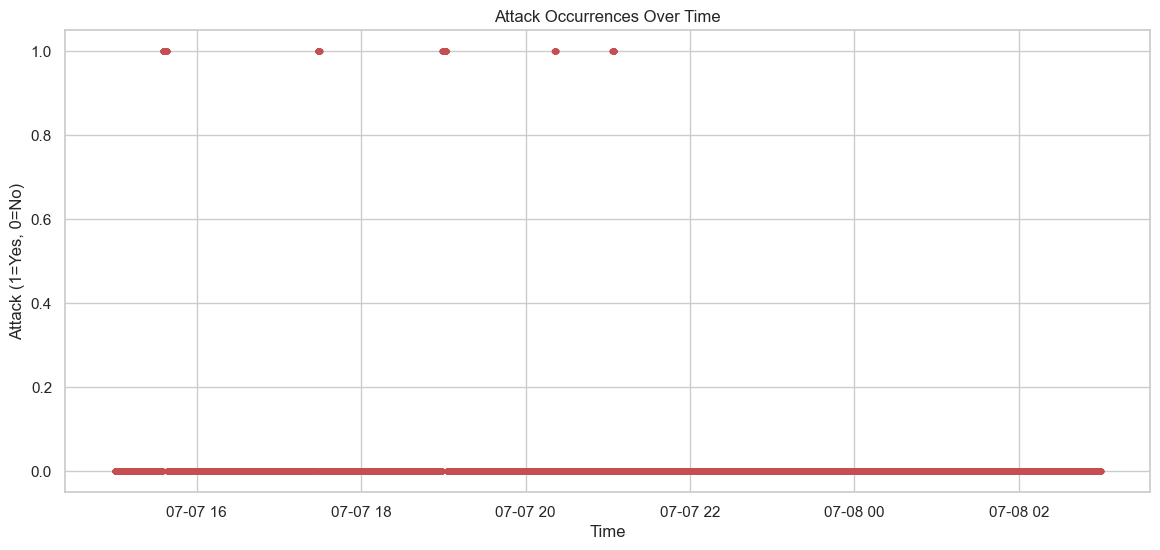

In [10]:
# Analyze attack patterns if 'attack' column exists
if parquet_files and 'attack' in df.columns:
    # Count attack vs non-attack instances
    attack_counts = df['attack'].value_counts()
    
    # Plot pie chart
    plt.figure(figsize=(10, 6))
    plt.pie(attack_counts, labels=['Normal', 'Attack'] if len(attack_counts) == 2 else None,
            autopct='%1.1f%%', startangle=90, colors=['lightgreen', 'salmon'])
    plt.title('Distribution of Normal vs Attack Instances')
    plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle
    plt.legend(['Normal', 'Attack'])
    plt.show()
    
    # If time column exists, plot attacks over time
    if time_column:
        plt.figure(figsize=(14, 6))
        plt.plot(df[time_column], df['attack'], 'r.', alpha=0.5)
        plt.title('Attack Occurrences Over Time')
        plt.xlabel('Time')
        plt.ylabel('Attack (1=Yes, 0=No)')
        plt.grid(True)
        plt.show()

## 10. Advanced Data Analysis (CPU-Compatible)

Performing CPU-based advanced analysis...

Basic statistics for selected columns:


,P1_B2004,P1_B2016,P1_B3004,P1_B3005,P1_B4002,P1_B4005,P1_B400B,P1_B4022,P1_FCV01D,P1_FCV01Z
count,43201.000000,43201.000000,43201.000000,43201.000000,43201.000000,43201.000000,43201.000000,43201.000000,43201.000000,43201.000000
mean,0.101221,1.396985,398.987740,1074.705235,32.317316,63.082296,1885.537917,36.056749,56.355013,56.188993
std,0.000484,0.127081,5.104598,46.375027,0.455703,40.130593,1152.533311,0.556682,42.174724,42.144635
min,0.100490,1.049520,394.214750,985.373530,31.816340,0.000000,28.005140,34.703660,0.000000,0.268550
25%,0.101090,1.322890,395.438260,1057.218380,31.816340,22.081260,712.246030,35.601640,14.917670,14.459230
50%,0.101090,1.396450,395.438260,1086.267580,32.431240,81.730390,2793.821050,36.092560,57.179540,57.260130
75%,0.101770,1.470140,403.788540,1115.262570,32.595270,100.000000,2836.356440,36.498820,100.000000,99.794000
max,0.101780,1.963000,406.612850,1115.262570,32.963250,100.000000,2860.185300,37.492030,100.000000,99.992370



Skewness and Kurtosis:


,Skewness,Kurtosis
P1_B2004,-0.169592,-1.265760
P1_B2016,0.252556,0.901623
P1_B3004,0.540887,-1.564894
P1_B3005,-0.966232,-0.374780
P1_B4002,0.092619,-1.521376
P1_B4005,-0.523785,-1.419712
P1_B400B,-0.639889,-1.342332
P1_B4022,-0.018306,-0.774322
P1_FCV01D,-0.098138,-1.805354
P1_FCV01Z,-0.100871,-1.807889


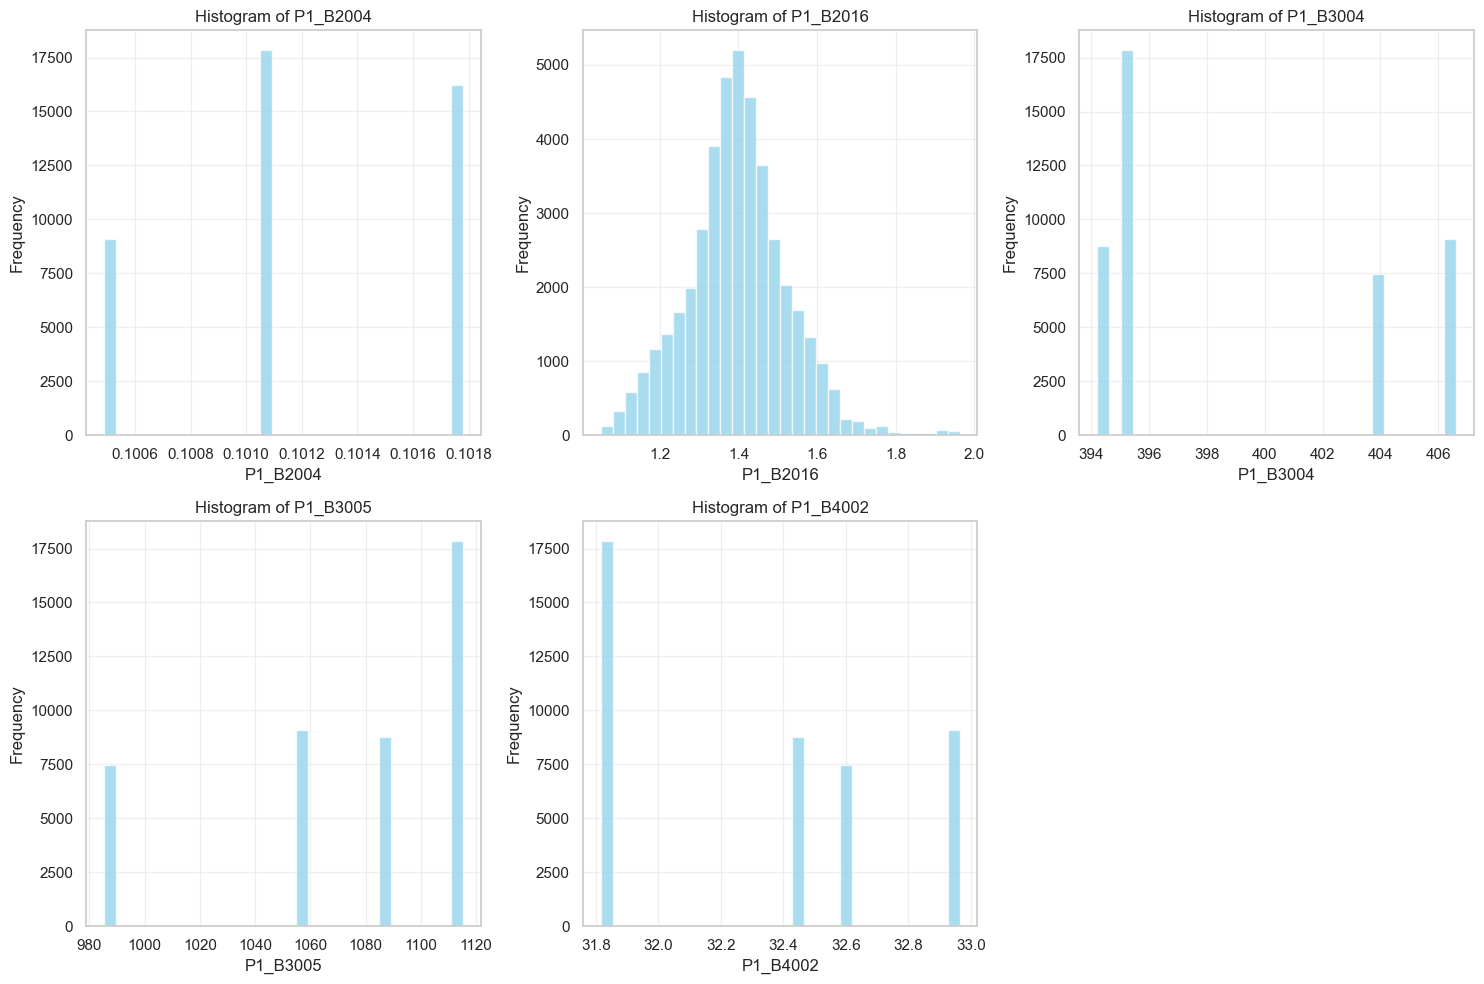

In [11]:
# CPU-based advanced analysis
if parquet_files:
    print("Performing CPU-based advanced analysis...")
    
    # Select numeric columns for analysis
    numeric_cols = df.select_dtypes(include=['number']).columns.tolist()
    
    # Remove time column if it exists
    if time_column and time_column in numeric_cols:
        numeric_cols.remove(time_column)
    
    # If there are too many columns, select a subset
    if len(numeric_cols) > 10:
        selected_cols = numeric_cols[:10]
    else:
        selected_cols = numeric_cols
    
    # Calculate basic statistics
    print("\nBasic statistics for selected columns:")
    display(df[selected_cols].describe())
    
    # Calculate skewness and kurtosis
    print("\nSkewness and Kurtosis:")
    skew_kurt = pd.DataFrame({
        'Skewness': df[selected_cols].skew(),
        'Kurtosis': df[selected_cols].kurtosis()
    })
    display(skew_kurt)
    
    # Plot histograms for selected columns
    plt.figure(figsize=(15, 10))
    for i, col in enumerate(selected_cols[:5]):  # Limit to first 5 columns for clarity
        plt.subplot(2, 3, i+1)
        plt.hist(df[col], bins=30, alpha=0.7, color='skyblue')
        plt.title(f'Histogram of {col}')
        plt.xlabel(col)
        plt.ylabel('Frequency')
        plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

## 11. Dimensionality Reduction with PCA (CPU-Compatible)

scikit-learn is available for CPU-based dimensionality reduction and clustering.
Standardizing data...
Applying PCA dimensionality reduction...
Explained variance ratio: [0.53118877 0.2335117 ]
Total explained variance: 0.76


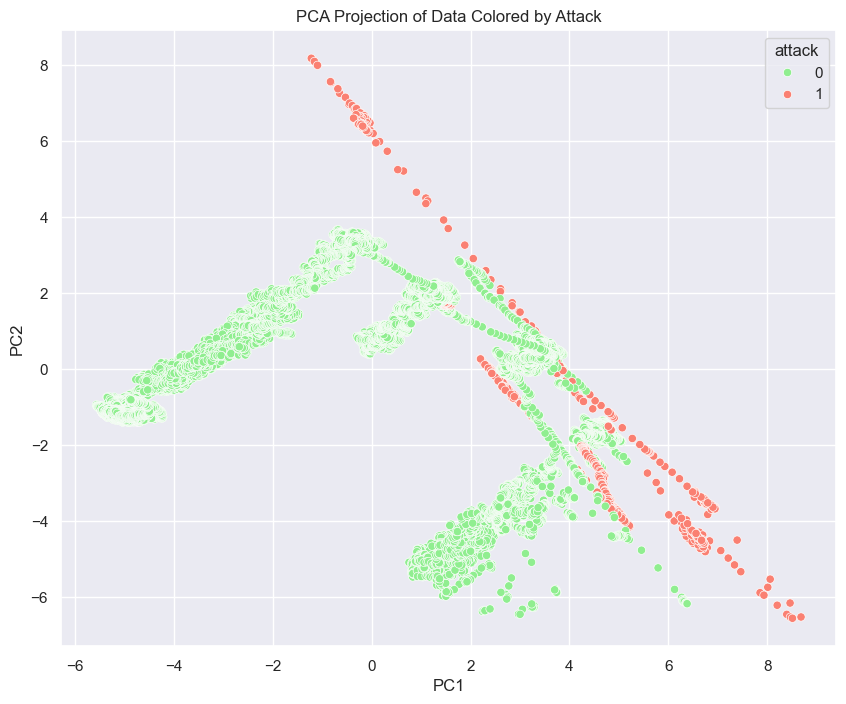

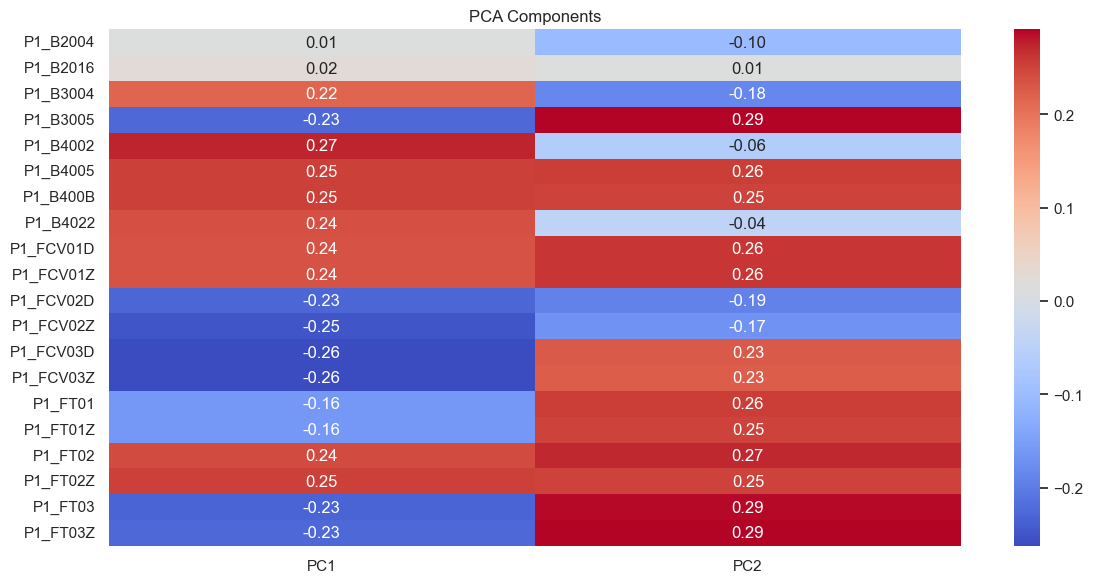

In [12]:
# Try to import scikit-learn for CPU-based dimensionality reduction
try:
    from sklearn.decomposition import PCA
    from sklearn.preprocessing import StandardScaler
    from sklearn.cluster import DBSCAN
    sklearn_available = True
    print("scikit-learn is available for CPU-based dimensionality reduction and clustering.")
except ImportError:
    sklearn_available = False
    print("scikit-learn is not available. Skipping dimensionality reduction and clustering.")

# Perform PCA and clustering if scikit-learn is available
if sklearn_available and parquet_files:
    try:
        # Select numeric columns for analysis
        numeric_cols = df.select_dtypes(include=['number']).columns.tolist()
        
        # Remove time and target columns if they exist
        if time_column and time_column in numeric_cols:
            numeric_cols.remove(time_column)
        if 'attack' in numeric_cols:
            numeric_cols.remove('attack')
        
        # If there are still too many columns, select a subset
        if len(numeric_cols) > 20:
            selected_cols = numeric_cols[:20]
        else:
            selected_cols = numeric_cols
        
        # Prepare data for PCA
        X = df[selected_cols].fillna(0)
        
        # Standardize the data
        print("Standardizing data...")
        scaler = StandardScaler()
        X_scaled = scaler.fit_transform(X)
        
        # Apply PCA for dimensionality reduction
        print("Applying PCA dimensionality reduction...")
        pca = PCA(n_components=2)
        X_pca = pca.fit_transform(X_scaled)
        
        # Create DataFrame for plotting
        pca_df = pd.DataFrame({
            'PC1': X_pca[:, 0],
            'PC2': X_pca[:, 1]
        })
        
        # Print explained variance
        print(f"Explained variance ratio: {pca.explained_variance_ratio_}")
        print(f"Total explained variance: {sum(pca.explained_variance_ratio_):.2f}")
        
        # If attack column exists, add it to the dataframe
        if 'attack' in df.columns:
            pca_df['attack'] = df['attack']
            
            # Plot PCA results colored by attack
            plt.figure(figsize=(10, 8))
            sns.scatterplot(x='PC1', y='PC2', hue='attack', data=pca_df, palette=['lightgreen', 'salmon'])
            plt.title('PCA Projection of Data Colored by Attack')
            plt.show()
        else:
            # Apply DBSCAN clustering
            print("Applying DBSCAN clustering...")
            dbscan = DBSCAN(eps=0.5, min_samples=5)
            clusters = dbscan.fit_predict(X_pca)
            
            # Add cluster labels to dataframe
            pca_df['cluster'] = clusters
            
            # Plot PCA results colored by cluster
            plt.figure(figsize=(10, 8))
            sns.scatterplot(x='PC1', y='PC2', hue='cluster', data=pca_df, palette='viridis')
            plt.title('PCA Projection of Data Colored by DBSCAN Cluster')
            plt.show()
            
        # Plot feature importance
        plt.figure(figsize=(12, 6))
        components = pd.DataFrame(pca.components_.T, columns=['PC1', 'PC2'], index=selected_cols)
        sns.heatmap(components, cmap='coolwarm', annot=True, fmt='.2f')
        plt.title('PCA Components')
        plt.tight_layout()
        plt.show()
            
    except Exception as e:
        print(f"Error performing dimensionality reduction and clustering: {str(e)}")

## 12. Summary and Conclusion

In this notebook, we have:

1. Converted HAI security datasets from CSV to Parquet format for more efficient processing
2. Analyzed the basic properties of the datasets
3. Visualized time series data and correlations between features
4. Analyzed attack patterns where applicable
5. Performed advanced data analysis using CPU-compatible methods
6. Applied dimensionality reduction with PCA and clustering with DBSCAN (if scikit-learn is available)

The Parquet format provides significant advantages for large datasets:
- Columnar storage for efficient querying
- Compression for reduced storage requirements
- Schema enforcement for data consistency
- Compatibility with big data tools like Apache Spark

For further analysis, you could:
- Build machine learning models to predict attacks
- Perform more detailed feature engineering
- Apply anomaly detection algorithms
- Compare different datasets to identify common patterns